In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [8]:

names = ['g', 'P', 'rho', 'r', 'T', 'Tm', 'Cp', 'alpha', 'gamma', 'Kt', 'Ka', 'G', 'sigma', 'phase']

titles =  [
    'Gravity', 'Pressure', 'Density', 'Temperature', 'Melt Temperature', 'Heat Capacity',
    'Thermal Expansivity', 'Grüneisen Parameter', 'Isothermal Bulk Modulus', 
    'Adiabatic Bulk Modulus', 'Shear Modulus', 'Electrical Conductivity', 'Material Phase Number'
]

profs = [
    'M1_Fe30_sFe6-5_pprofs.res', 'M1_Fe60_sFe6-5_pprofs.res', 'M2_Fe30_sFe6-5_pprofs.res',
    'M2_Fe60_sFe6-5_pprofs.res', 'M3_Fe30_sFe6-5_pprofs.res', 'M3_Fe60_sFe6-5_pprofs.res',
    'M4_Fe30_sFe6-5_pprofs.res', 'M4_Fe60_sFe6-5_pprofs.res', 'M5_Fe30_sFe6-5_pprofs.res',
    'M5_Fe60_sFe6-5_pprofs.res'
]

lbl = [r'1 M  30% Fe', r'1 M  60% Fe', r'2 M  30% Fe', r'2 M  60% Fe', r'3 M  30% Fe',
    r'3 M  60% Fe', r'4 M  30% Fe', r'4 M  60% Fe', r'5 M  30% Fe', r'5 M  60% Fe'
       ]

clrs= np.array([[255, 195, 0], [255, 87, 51], [199, 0, 57], [144, 12, 63], [88, 24, 69]]) / 255

# from profs.res load the data as a dataframe with 14 columns that are delimitered by whitespace
planets = {}
labels = {}
for prof in profs:
    df = pd.read_csv(prof,delimiter=r'\s+', names=names)
    for i in range(len(df['phase'])):
        if df['phase'][i] == 8.0:
            cmb = i
            # delete all values after index cmb
            break
    df = df.drop(df.index[:cmb])
    i = profs.index(prof)
    # convert the index from 0 to 511
    ncmb = 1000-cmb
    df.index = range(0,ncmb)
    reverse = df[::-1]

    # corrections
    df['n'] = ncmb
    df['r'] = df['r']-df['r'][ncmb-1]
    df['P'] = df['P']*1.0e9
    df['alpha'] = df['alpha']*1.0e-5
    prof = prof[0:6]
    planets[prof] = df
    labels[prof] = lbl[i]


In [9]:
prof = 'M1_Fe3'
T = planets[prof]['T']
r = planets[prof]['r']
rho = planets[prof]['rho']
Cp = planets[prof]['Cp']
r = r[::-1]
Tc = planets[prof]['T'][0]
dr = r[0]-r[1]
n = len(r)-1

rho_c = rho[n]
Cp_c = Cp[n]

dTcdt = -5 * 1.0e-16

Vc = 4/3*np.pi*r[0]**3

QS1 = Vc * rho_c * Cp_c * sp.integrate.simpson(T,x=r,dx=dr)/Tc * 1.0e-12 * dTcdt
QS2 = 4*np.pi*sp.integrate.simpson(Cp*rho*T*r**2,x=r,dx=dr)/Tc * 1.0e-12 * dTcdt

print(len(r))
print(r[0])
print(f"QS1: {QS1}")
print(f"QS2: {QS2}")
print(f"QS1-QS2: {round((QS1-QS2)/QS1*100,2)}%")

qad = 125 * planets[prof]['alpha'][n] * planets[prof]['g'][n] / planets[prof]['Cp'][n] * planets[prof]['T'][n]
print(f"q_ad: {qad}")

489
3062904.1492402
QS1: -3331640.1279026377
QS2: -0.9803582862427965
QS1-QS2: 100.0%
q_ad: 0.00011840062792265805


In [10]:
rtc = 3041843.3227286106
rc = 60.0+rtc
rb = 24905.865608419765+rc+rtc
km = 9.9273790821881729 
rhom = 5536.0  
rhoc = 11546.0
Hc = 1.0e-12
Hm = 2.0e-12
kc = 125.0
Tb = 4173.3167184879076 

Ttc = 4173.4654945261318

# Placeholder values
c1m = 0.0
c0m = 0.0
c1c = 0.0
c0c = 0.0

# dq/dr + 2q/r = pho*H --> T = -rho*H/(6*k) + c1/r + c0

# Construct matrix A
n_la = 5  # Define n_la based on your specific use case
A = np.array([
    [1.0, 1.0/rb, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, -rc*rb/(rb-rc)],
    [0.0, 0.0, 1.0, 1.0/rc, -1.0],
    [0.0, 0.0, 0.0, 1.0, rtc*rc/(rc-rtc)],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])

# Construct vector b
b = np.zeros(n_la)
b[0] = Tb + rhom*Hm/(6.0*km)*rb**2
b[1] = Tb*rb*rc/(rb-rc)-rhom*Hm/(6.0*km)*(rc**2*rb+rc*rb**2)
b[2] = rhoc*Hc/(6.0*kc)*rc**2
b[3] = Ttc*rtc*rc/(rc-rtc)-rhoc*Hc/(6.0*kc)*(rc**2*rtc+rc*rtc**2)
b[4] = (Ttc+Tb*km/kc*(rc-rtc)/(rb-rc))/(1+km/kc*(rc-rtc)/(rb-rc))

# Solve the linear system A * x = b
try:
    x = np.linalg.solve(A, b)
except np.linalg.LinAlgError:
    print("Error: The solution could not be computed.")
    exit()

# Extract the results
c1m = x[0]
c0m = x[1]
c1c = x[2]
c0c = x[3]
Tc = x[4]  # New temperature at the core-mantle boundary

#initially: Tc = 4172.9766230460846
print(f"Found Tc: {Tc} K")
print(Ttc-Tc)

Found Tc: 4173.465494294963 K
2.311689968337305e-07


In [17]:
data_PREM = np.genfromtxt('PREM500.csv', delimiter=',', skip_header=1)
PREM_r = data_PREM[:,0]
PREM_rho = data_PREM[:, 1]
# Define new radius values (for example, n=1000)
n=1000
r = np.linspace(min(PREM_r), max(PREM_r), n)
G = 6.6743e-11

# Interpolate density to the new radius values
density_interpolator = sp.interpolate.interp1d(PREM_r, PREM_rho, kind='linear', fill_value="extrapolate")
rho = density_interpolator(r)

# Initialize arrays for mass, gravitational acceleration, and pressure
M = np.zeros_like(r)
g = np.zeros_like(r)
P = np.zeros_like(r)

# Compute mass, gravitational acceleration, and pressure
for i in range(1, len(r)):
    # Integrate mass up to radius r[i] using the trapezoidal rule
    M[i] = 4 * np.pi * np.trapz(rho[:i+1] * r[:i+1]**2, r[:i+1])
    
    # Compute gravitational acceleration at radius r[i]
    g[i] = G * M[i] / r[i]**2
    
    # Compute pressure at radius r[i] using hydrostatic equilibrium
    P[i] = P[i-1] + np.trapz(-rho[i-1:i+1] * g[i-1:i+1], r[i-1:i+1])

P = (P-P[-1])/1e9 # [GPa]

# find r core where g is maximum
rc = r[np.argmax(g)]

# find the density jump at the inner core boundary where rho suddenly increases
ri = r[np.argmax(-1*np.gradient(rho[:np.argmax(g)]))]

def V(r):
    return 4/3*np.pi*(r)**3

x0 = 0.11
x_ini = x0-x0*V(ri)/V(rc) #earth
rc_p = planets[prof]['r'][0]
ri_p = planets[prof]['r'][199]
planets[prof]['x0'] = x_ini*V(rc)/(V(rc)-V(ri))

print(f"Earth Core radius: {rc} m")
print(f"Earth Inner core radius: {ri} m")
print(f'Inner core volume of earth {ri**3/rc**3:.2%}')
print(f'Initial concetration of light elements in earth {x_ini:.2%}')
print()
print(f"Core radius: {rc_p} m")
print(f"Inner core boundary: {ri_p} m")
print(f'Inner core volume of {prof} {ri_p**3/rc_p**3:.2%}')
print(f'Outer core concentration of {prof} {x_ini*V(rc_p)/(V(rc_p)-V(ri_p)):.2%}')

Earth Core radius: 3481514.046046046 m
Earth Inner core radius: 1215749.7297297297 m
inner core volume of earth 4.26%
initial concetration of light elements in earth 10.53%

Core radius: 3062904.1492402 m
Inner core boundary: 1813892.0064148 m
inner core volume of M1_Fe3 20.77%
outer core concentration of M1_Fe3 13.29%


5540.592144 7052.2082909733


C:\Users\louis\AppData\Local\Temp\ipykernel_38412\2108763304.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  Temp[i] = T1[0] * np.exp(-sp.integrate.simps(alpha[:i]*g[:i]/Cp[:i],x=r[:i]))


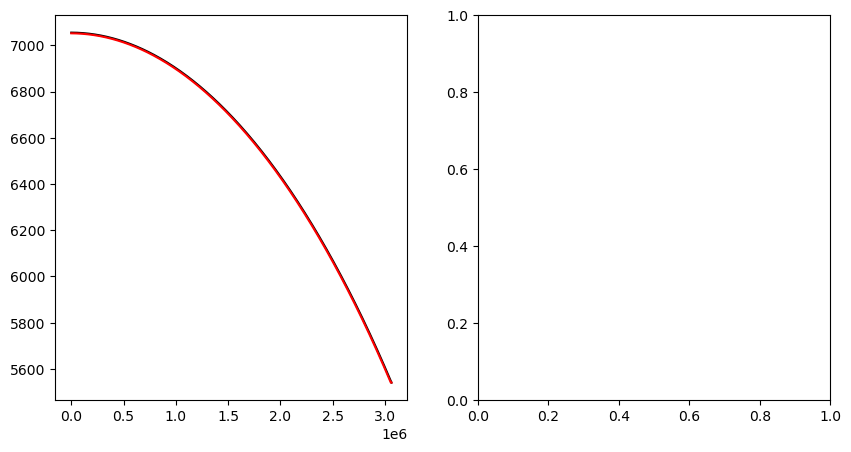

In [56]:
T1 = np.array(planets[prof]['T'])
r = np.array(planets[prof]['r'])
g = np.array(planets[prof]['g'])
alpha = np.array(planets[prof]['alpha'])
Cp = np.array(planets[prof]['Cp'])

def T(r):
    Temp = np.zeros_like(r)
    Temp[0] = T1[0]
    for i in range(len(r)-1):
        i = len(r)-(i+1)
        Temp[i] = T1[0] * np.exp(-sp.integrate.simps(alpha[:i]*g[:i]/Cp[:i],x=r[:i]))
    return Temp

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(r, T1, label='T1',color = 'k')
ax[0].plot(r, T(r), label='T2',color = 'r')